In [1]:
!pip install wbdata

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.7/295.7 kB 19.5 MB/s eta 0:00:00
  Attempting uninstall: tabulate
    Found existing installation: tabulate 0.9.0
    Uninstalling tabulate-0.9.0:
      Successfully uninstalled tabulate-0.9.0
  Attempting uninstall: decorator
    Found existing installation: decorator 4.4.2
    Uninstalling decorator-4.4.2:
      Successfully uninstalled decorator-4.4.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.34.0 requires jedi>=0.16, which is not installed.
moviepy 1.0.3 requires decorator<5.0,>=4.0.2, but you have decorator 5.2.1 which is incompatible.
bigframes 2.4.0 requires tabulate>=0.9, but you have tabulate 0.8.10 which is incompatible.


In [1]:

import wbdata
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

In [2]:
# Function to fetch macroeconomic data from World Bank
def fetch_wb_data(indicator, country='USA', start_year=1960, end_year=2023):
    try:
        data = wbdata.get_data(indicator=indicator, country=country)
        df = pd.DataFrame([
            {'date': pd.to_datetime(d['date']), 'value': d['value']}
            for d in data if d['value'] is not None
        ])
        df = df.sort_values('date').set_index('date')
        df['value'] = pd.to_numeric(df['value'], errors='coerce')
        df = df.dropna()
        return df[(df.index.year >= start_year) & (df.index.year <= end_year)]
    except Exception as e:
        print(f"Error fetching data: {e}")
        return None

In [3]:
# Function to create additional features
def create_features(df):
    df = df.copy()
    df['lag_1'] = df['value'].shift(1)  # 1-year lag
    df['lag_2'] = df['value'].shift(2)  # 2-year lag
    df['rolling_mean'] = df['value'].rolling(window=3).mean()  # 3-year rolling mean
    df['rolling_std'] = df['value'].rolling(window=3).std()  # 3-year rolling std
    return df.dropna()

In [4]:
# Function to preprocess data
def preprocess_data(data, look_back=5, feature_columns=['value', 'lag_1', 'lag_2', 'rolling_mean', 'rolling_std']):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data[feature_columns])

    X, y = [], []
    for i in range(look_back, len(scaled_data)):
        X.append(scaled_data[i-look_back:i])
        y.append(scaled_data[i, 0])  # Predict 'value' column
    X, y = np.array(X), np.array(y)

    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    return X_train, y_train, X_test, y_test, scaler

In [5]:
# Function to build and train LSTM model
def build_lstm_model(X_train, y_train, look_back=5, feature_count=5):
    model = Sequential()
    model.add(LSTM(units=100, return_sequences=True, input_shape=(look_back, feature_count)))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50))
    model.add(Dropout(0.2))
    model.add(Dense(units=25))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')

    early_stopping = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
    model.fit(X_train, y_train, epochs=100, batch_size=16, verbose=1, callbacks=[early_stopping])
    return model

In [6]:
# Function to make predictions
def make_predictions(model, X_test, scaler, feature_columns=['value', 'lag_1', 'lag_2', 'rolling_mean', 'rolling_std']):
    predictions = model.predict(X_test)
    # Inverse transform predictions (only for 'value' column)
    dummy = np.zeros((len(predictions), len(feature_columns)))
    dummy[:, 0] = predictions[:, 0]
    predictions = scaler.inverse_transform(dummy)[:, 0]
    return predictions

In [7]:
# Function to inverse transform actual values
def inverse_transform_actual(y_test, scaler, feature_columns=['value', 'lag_1', 'lag_2', 'rolling_mean', 'rolling_std']):
    dummy = np.zeros((len(y_test), len(feature_columns)))
    dummy[:, 0] = y_test
    return scaler.inverse_transform(dummy)[:, 0]

Fetching GDP growth data from World Bank...
Training LSTM model...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - loss: 0.3242
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.1134
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0523
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0858
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0571
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0448 
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0566
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0541
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0556
Epoch 10/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0525
Epoch 11/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0563 
Epoch 12/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0662
Epoch 13/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0477
Epoch 14/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0558
Epoch 15/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0468
Epoch 16/100
3/3 

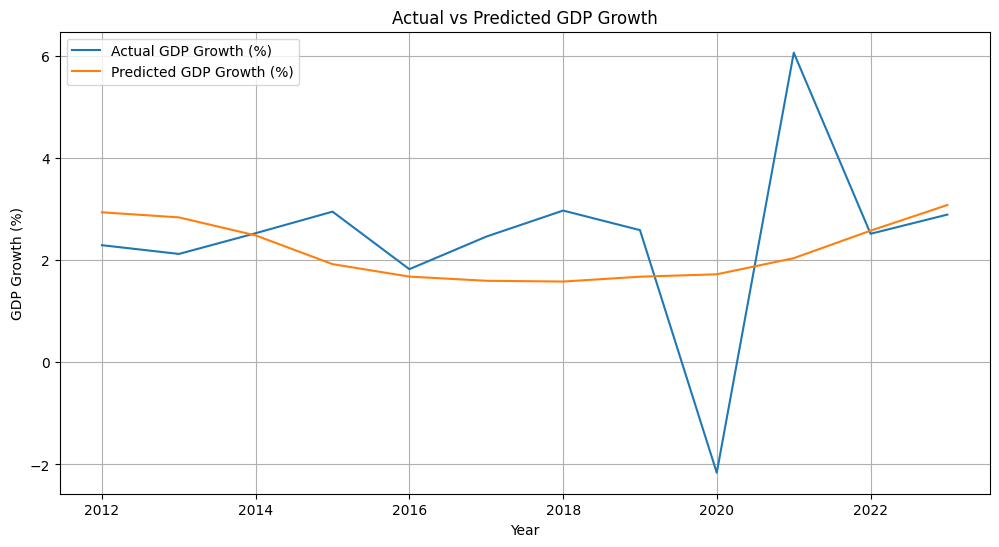

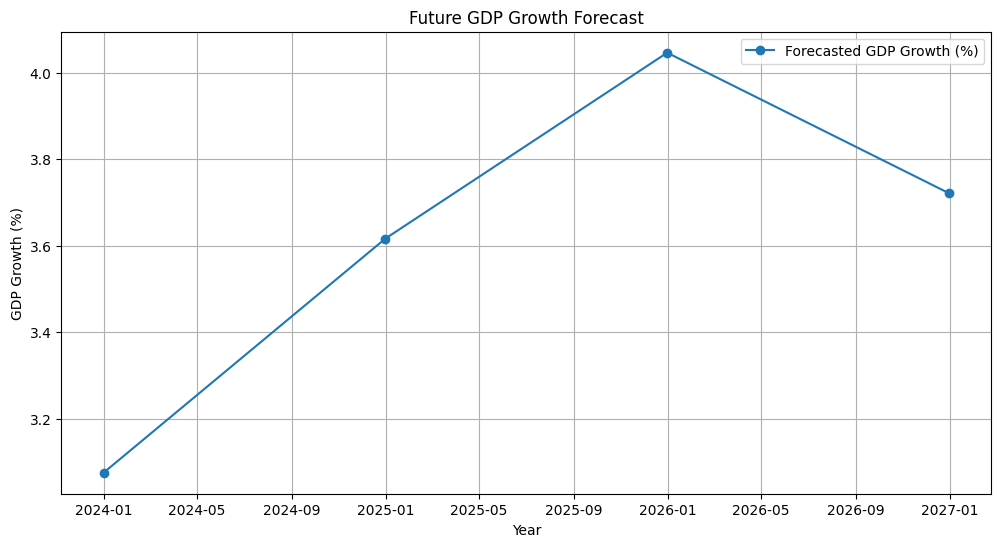

In [13]:

# Main execution
def main():
    # Fetch GDP growth data (annual %)
    indicator = 'NY.GDP.MKTP.KD.ZG'  # GDP growth (annual %)
    print("Fetching GDP growth data from World Bank...")
    gdp_data = fetch_wb_data(indicator)
    if gdp_data is None:
        return

    # Create features
    data_with_features = create_features(gdp_data)

    # Preprocess data
    look_back = 5
    feature_columns = ['value', 'lag_1', 'lag_2', 'rolling_mean', 'rolling_std']
    X_train, y_train, X_test, y_test, scaler = preprocess_data(data_with_features, look_back, feature_columns)

    # Train model
    print("Training LSTM model...")
    model = build_lstm_model(X_train, y_train, look_back, len(feature_columns))

    # Make predictions
    predictions = make_predictions(model, X_test, scaler, feature_columns)
    y_test_scaled = inverse_transform_actual(y_test, scaler, feature_columns)

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_test_scaled, predictions))
    print(f"Test RMSE: {rmse:.4f}")

    # Plot actual vs predicted
    test_dates = data_with_features.index[-len(y_test):]
    plt.figure(figsize=(12, 6))
    plt.plot(test_dates, y_test_scaled, label="Actual GDP Growth (%)")
    plt.plot(test_dates, predictions, label="Predicted GDP Growth (%)")
    plt.title("Actual vs Predicted GDP Growth")
    plt.xlabel("Year")
    plt.ylabel("GDP Growth (%)")
    plt.legend()
    plt.grid(True)
    plt.show()
    # Forecast future values (4 years ahead)
    future_steps = 4
    last_sequence = X_test[-1]
    future_predictions = []
    current_sequence = last_sequence.copy()

    for _ in range(future_steps):
        current_sequence = np.reshape(current_sequence, (1, look_back, len(feature_columns)))
        next_pred = model.predict(current_sequence, verbose=0)
        future_predictions.append(next_pred[0, 0])
        # Shift sequence and append new prediction
        current_sequence = np.roll(current_sequence, -1, axis=1)
        current_sequence[0, -1, 0] = next_pred[0, 0]
        # Approximate other features (e.g., lags and rolling stats)
        for i in range(1, len(feature_columns)):
            current_sequence[0, -1, i] = current_sequence[0, -2, i]  # Carry forward last known value

    future_predictions = inverse_transform_actual(np.array(future_predictions), scaler, feature_columns)

    # Generate future dates
    last_date = data_with_features.index[-1]
    future_dates = [last_date + timedelta(days=365 * (i + 1)) for i in range(future_steps)]

    # Plot future forecasts
    plt.figure(figsize=(12, 6))
    plt.plot(future_dates, future_predictions, label="Forecasted GDP Growth (%)", marker='o')
    plt.title("Future GDP Growth Forecast")
    plt.xlabel("Year")
    plt.ylabel("GDP Growth (%)")
    plt.legend()
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    main()
